In [1]:
import tensorflow as tf
import numpy as np
from IPython import display
from pathlib import Path

from lib.data import SequenceGenerator
from lib.image import write_png

box_size = 49

2023-04-27 14:37:05.721285: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-27 14:37:05.918723: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-27 14:37:05.921681: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 14:37:08.821374: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


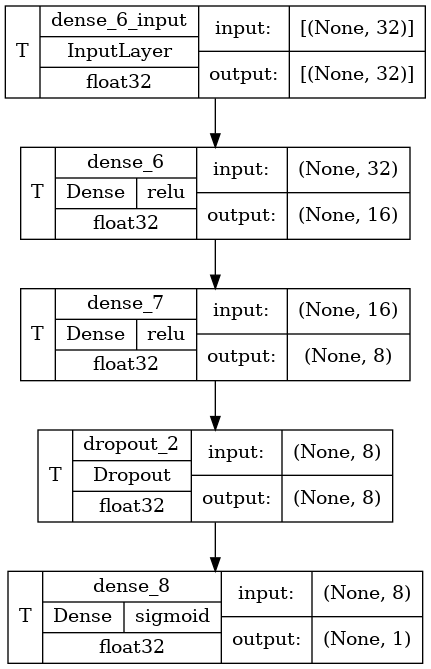

In [19]:


dropout = tf.keras.layers.Dropout(0.5)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(16, activation='relu', input_shape=(32,)),
  tf.keras.layers.Dense(8, activation='relu'),
  dropout,
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='Adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['binary_accuracy', tf.keras.metrics.FalseNegatives(name='false_negatives'), tf.keras.metrics.FalsePositives(name='false_positives')]
              )

tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, show_layer_activations=True, show_trainable=True)
display.Image(f'model.png')

In [3]:
gen = SequenceGenerator('img/project-1-at-2023-04-26-18-24-a552911a.json', 'img/raw')
train_data = gen.create_conv_sequence(box_size, 32, False)
validation_data = gen.create_conv_sequence(box_size, 512, True)


In [26]:
import datetime

#dropout = model.get_layer('dropout')
#model.optimizer.learning_rate = 0.0005
#dropout.rate = 0.8

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


model.fit(x=train_data,
          epochs=14,
          validation_data=validation_data,
          callbacks=[tensorboard_callback])

Epoch 1/14
  3/226 [..............................] - ETA: 6s - loss: 0.0333 - binary_accuracy: 0.9896 - false_negatives: 1.0000 - false_positives: 0.0000e+00     

2023-04-27 17:44:38.388529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


226/226 [==============================] - ETA: 0s - loss: 0.0629 - binary_accuracy: 0.9776 - false_negatives: 145.0000 - false_positives: 17.0000

2023-04-27 17:44:44.477337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


226/226 [==============================] - 7s 31ms/step - loss: 0.0629 - binary_accuracy: 0.9776 - false_negatives: 145.0000 - false_positives: 17.0000 - val_loss: 0.0237 - val_binary_accuracy: 0.9880 - val_false_negatives: 9.0000 - val_false_positives: 11.0000
Epoch 2/14
226/226 [==============================] - 7s 29ms/step - loss: 0.0671 - binary_accuracy: 0.9745 - false_negatives: 164.0000 - false_positives: 20.0000 - val_loss: 0.0239 - val_binary_accuracy: 0.9892 - val_false_negatives: 10.0000 - val_false_positives: 8.0000
Epoch 3/14
226/226 [==============================] - 7s 31ms/step - loss: 0.0674 - binary_accuracy: 0.9732 - false_negatives: 169.0000 - false_positives: 25.0000 - val_loss: 0.0250 - val_binary_accuracy: 0.9886 - val_false_negatives: 8.0000 - val_false_positives: 11.0000
Epoch 4/14
226/226 [==============================] - 7s 30ms/step - loss: 0.0641 - binary_accuracy: 0.9750 - false_negatives: 161.0000 - false_positives: 20.0000 - val_loss: 0.0254 - val_bina

In [14]:
model.save_weights('model.tf')
model.save('model-all')

2023-04-27 01:22:48.628760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-27 01:22:49.022473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: model-all/assets


INFO:tensorflow:Assets written to: model-all/assets


In [31]:
model.load_weights('model.tf')

In [3]:
model = tf.keras.models.load_model('model-all')

In [ ]:
for i in range(len(validation_data)):
    batch_x, batch_y = validation_data[i]
    batch_r = model(batch_x)
    for k in range(len(batch_x)):
        y = round(float(batch_y[k]))
        r = round(float(batch_r[k]))
        if y != r:
            data, image, image_data = validation_data.get_details(i, k)
            name = f'./tmp/{r}-{y}--{i}-{k}--{data[1]}x{data[2]}.png'
            #print(name, image_data.info.file, image_data.info.slice_index)
            write_png(name, image)


In [55]:

for i in range(len(validation_data.data)):
    if validation_data.data[i][0] == 1:
        batch_index = i // validation_data.batch_size
        data_index = i % validation_data.batch_size
        break
data, image, image_data = validation_data.get_details(batch_index, data_index)
print(data)
out = np.array(image_data.data)
#for y in range(box_size, image_data.info.height - box_size):
#for y in range(150, 1608-150):
for y in range(150, 1608-150):
    sec = []
    for x in range(150, 1608-150):
        sec.append(validation_data._get_section((data[0], x, y, 0)))
    res = model(np.array(sec))
    out[y, 150:1608-150] = res.numpy().reshape((1308,))
    print(f'{y}   ', end='\r')
    if y % 50 == 0:
        write_png('./tmp/b.png', out)


(1, 1188, 601, 0)


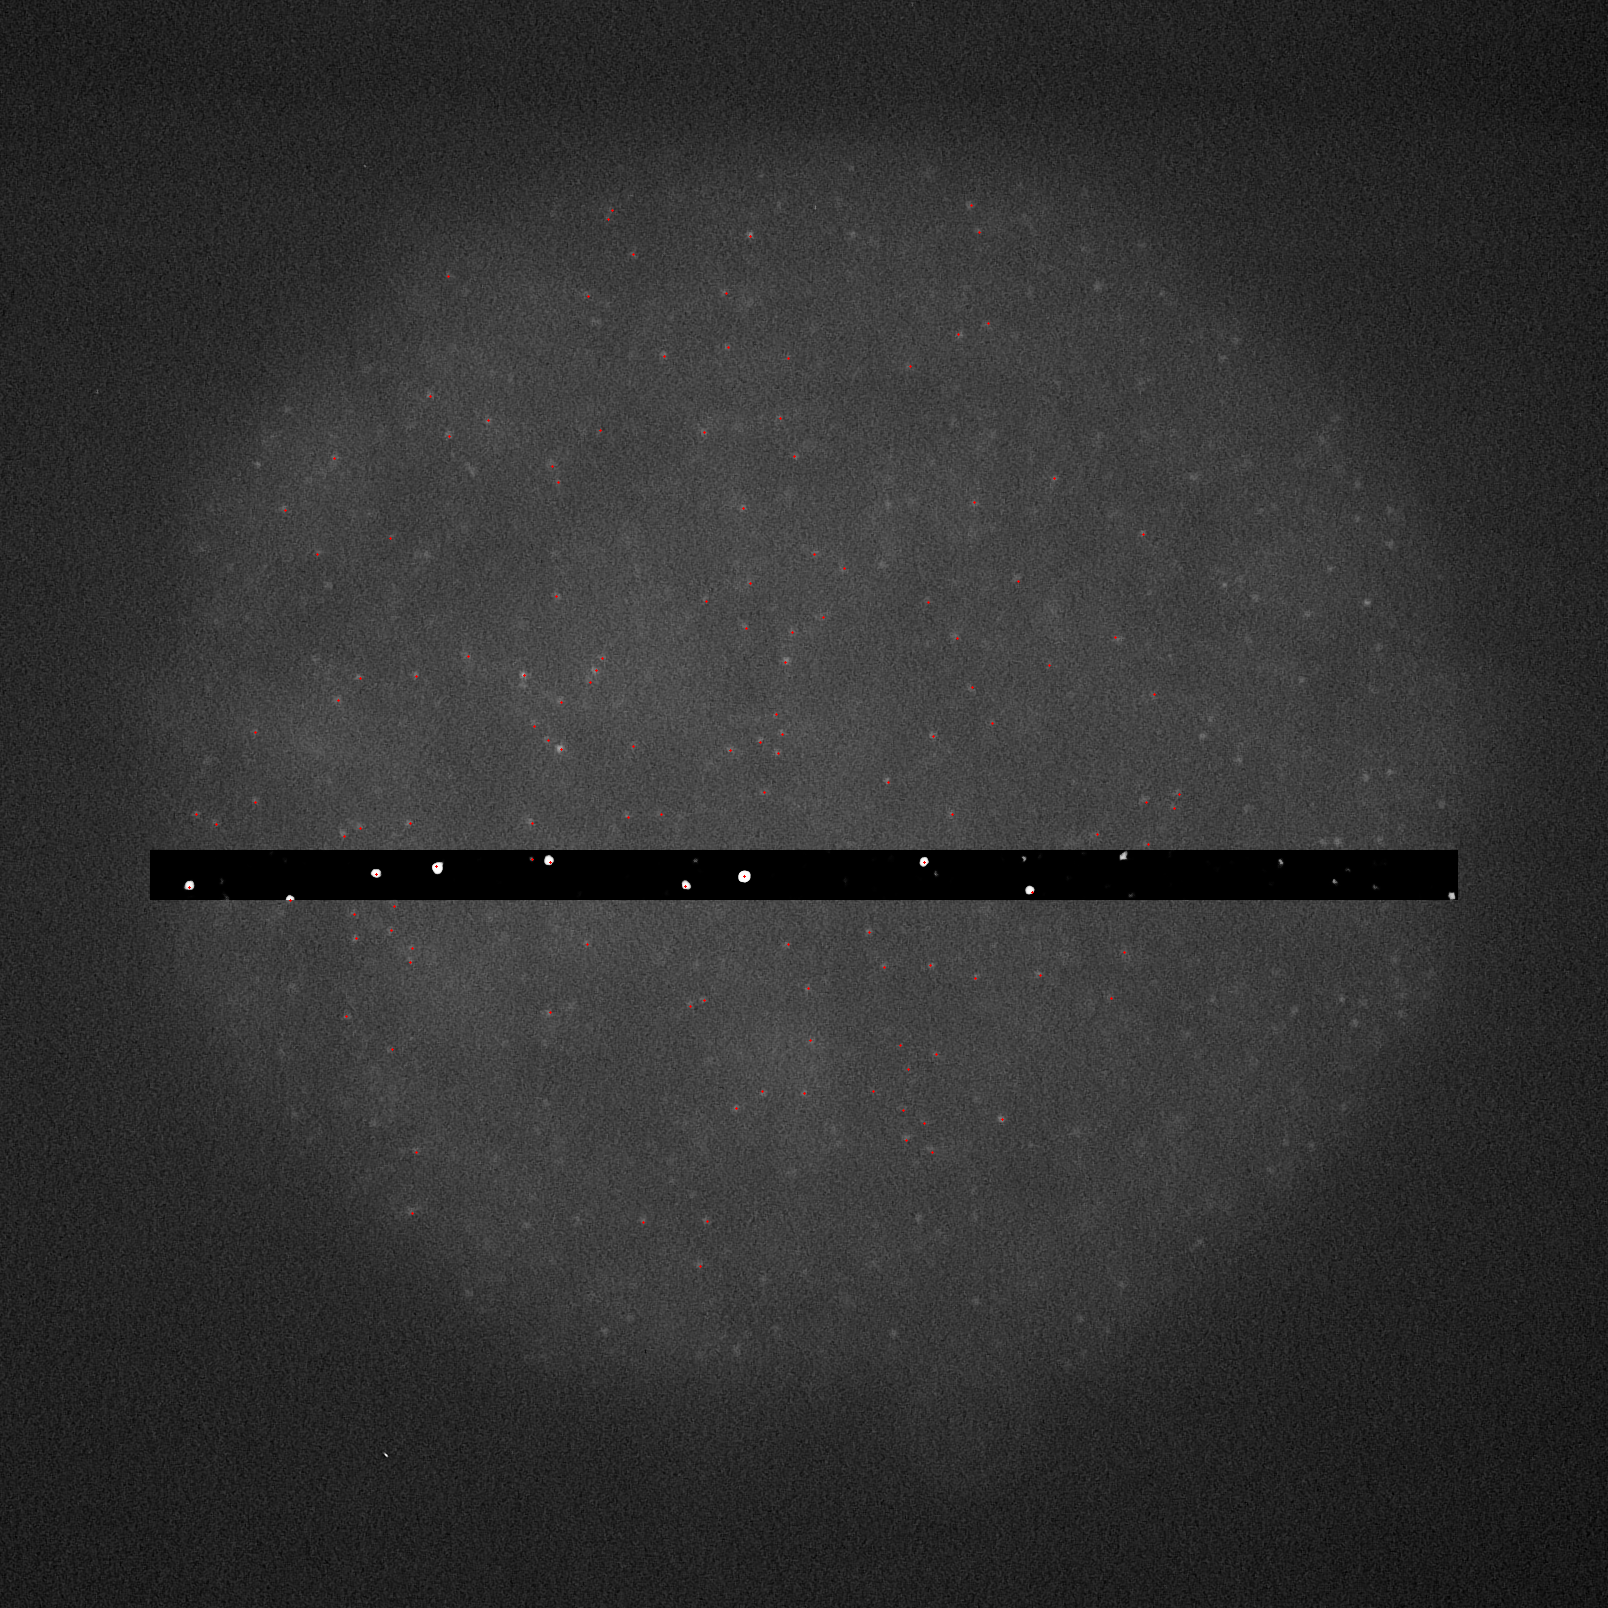

In [54]:
import png
import itertools

def data_to_row(data, data2, width):
    row = np.zeros((width, 3), np.uint8)
    row[:,0] = np.where(data2 != 0, 255, data.reshape((width,)))
    row[:,1] = np.where(data2 != 0, 0, data.reshape((width,)))
    row[:,2] = np.where(data2 != 0, 0, data.reshape((width,)))
    return row.reshape((3 * width))

def write_png2(filename: 'Path|str', data: 'np.ndarray', black: float = 0, white: float = 1):
    shape = data.shape
    w = png.Writer(shape[1], shape[0], bitdepth=8, greyscale=False)
    with open(filename, 'wb') as fd:
        w.write(fd, [
            data_to_row(((data[y] - black) / (white - black) * 255.0).astype(np.uint8), data2[y], shape[0])
            for y in range(0, shape[0])])
    return filename

data2 = np.zeros(out.shape, np.uint8)

for p in itertools.chain(train_data.data, validation_data.data):
    if p[0] != data[0]: continue
    if p[3] != 1: continue
    data2[p[2], p[1]] = 1
    data2[p[2]+1, p[1]] = 1
    data2[p[2], p[1]-1] = 1
    data2[p[2]-1, p[1]] = 1
    data2[p[2], p[1]+1] = 1

write_png2('./tmp/b.png', out)
display.Image(f'./tmp/b.png')